# **Can Social Media Sentiment Drive Stock Prices?**

# _Book 1: Reddit Data - Data Wrangling and Cleaning_


## Table of Contents
[Introduction and Problem Statement](#Introduction-and-Problem-Statement)\
[Reddit Data Set](#Reddit-Data-Set)
- [Basic EDA](#Basic-EDA)
- [Check for Null/NaN values and Duplicates](#Check-for-Null/NaN-values-and-Duplicates)
- [Remove Features that are not needed](#Remove-Features-that-are-not-needed)

[Preprocess for VADER](#Preprocess-for-VADER)
- [Cleaning the text data in `cleaned_posts`](#Cleaning-the-text-data-in-`cleaned_posts`)
- [Remove Stop Words](#Remove-Stop-Words)

[Sentiment Scoring using VADER](#Sentiment-Scoring-using-VADER)
- [Weighted Sentiment](#Weighted-Sentiment)

## Introduction and Problem Statement
Predicting stock market movement and trends is of great interest to both individuals and companies. In order to make informed and secure decisions, traders need to forecast stock trends - determine buy/sell opportunities. The stock market is notoriously difficult to predict, stocks are inherently volatile. Besides the traditional historical analysis of the stock data there are several socio-economic external factors, such as social media and financial news.

We are living in the day and age of fast media and information. News, thoughts, emotions are constantly shared instantly. Social media has millions of users posting hundreds of millions of posts daily - there are many outlets for millions of users to share information.

Traditionally stock market analysis solely took an interest in the historical movement of the stock pricing. This is not enough anymore, not with the growing social media presence of companies and how quickly that information is shared worldwide.

Social media sentiment analysis provides insights into positive or negative views on stocks, trends and the company itself. Sentiment about companies, about stock movements are shared on a regular basis. To analyze this sentiment is crucial to navigate the complex field of stock market analysis.

### Approach

For this analysis we will be interested in only analyzing TSLA (Tesla Inc.) stock and utilizing Reddit as our social media posts. Reddit is a great form of social media because there are several subreddits that are devoted solely for stocks and stock analysis, which means there is abundant information that can be collected for stock sentiment.

Book 1 will focus on the EDA, text cleaning and preparation of the text data to run sentiment analysis. Once the preprocessing steps are completed we can perform our sentiment scoring.The sentiment score that will be modeled here will then be used collectively with our stock data/information to predict the stock outcome.

We will be utilizing ***VADER*** (Valance Aware Dictionary and sEntiment Reasoner) a strong sentiment model that uses the bag of words approach to calculating the sentiment scores. VADER is a great module because it reads informal language, sentence structure and even emojiis. That is why VADER is perfect for predicting the sentiment of social media texts.

### Import Python Packages

In [ ]:
# import the basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats

# financial package
import yfinance as yf

# NLP packages
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from string import punctuation

# import sklearn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Reddit Data Set

The data was sourced from [Kaggle](https://www.kaggle.com/datasets/pavellexyr/one-year-of-tsla-on-reddit).

In [ ]:
reddit_comment_df = pd.read_csv('data/one-year-of-tsla-on-reddit-comments.csv')
reddit_posts_df = pd.read_csv('data/one-year-of-tsla-on-reddit-posts.csv')

In [ ]:
# to see all the columns in the data sets.
pd.options.display.max_columns=None

We have 2 separate data frames for comments and posts. We will check if they can be joined on a specific column.

The reason the 2 separate data frames will be useful as a combined data frame is because the associated `score` column -- this will be used as a multiplier to our sentiment score. This will be discussed in detail below.

In [ ]:
reddit_comment_df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,ievql0n,2rndg,valueinvesting,False,1656978625,https://old.reddit.com/r/ValueInvesting/commen...,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1
1,comment,ievpqay,2qjfk,stocks,False,1656978201,https://old.reddit.com/r/stocks/comments/vrje7...,$TSLA will go down because you own the stock… ...,0.2136,1
2,comment,ievo646,2th52,wallstreetbets,False,1656977438,https://old.reddit.com/r/wallstreetbets/commen...,TSLA 🚀🚀🚀🚀🚀🚀🚀,NaN,4
3,comment,ievn2mn,2qstm,personalfinance,False,1656976905,https://old.reddit.com/r/personalfinance/comme...,"&gt;What I mean is when I started investing, t...",0.7748,8
4,comment,ievn0i7,2qstm,personalfinance,False,1656976877,https://old.reddit.com/r/personalfinance/comme...,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2


In [ ]:
reddit_posts_df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,vrkdvj,4430vb,ultraalgo,False,1656977609,https://old.reddit.com/r/UltraAlgo/comments/vr...,pbs.twimg.com,http://pbs.twimg.com/media/FW2_yU1WQAEiRgC.jpg,NaN,$TSLA $1038 net profit across 11 trades. 90% A...,2
1,post,vrjowr,2th52,wallstreetbets,False,1656975472,https://old.reddit.com/r/wallstreetbets/commen...,i.redd.it,https://i.redd.it/cgnm1ptsao991.jpg,NaN,TSLA 800.85 INCOMING,1
2,post,vrjb37,2th52,wallstreetbets,False,1656974317,https://old.reddit.com/r/wallstreetbets/commen...,i.redd.it,https://i.redd.it/0vyq8v2d7o991.jpg,NaN,TSLA 800.85 this week,1
3,post,vriek0,n9evv,teslainvestorsclub,False,1656971708,https://old.reddit.com/r/teslainvestorsclub/co...,twitter.com,https://twitter.com/garyblack00/status/1544000...,NaN,Gary Black on Twitter: $TSLA delivered 157.9K ...,53
4,post,vrea7h,32a4fr,ai_trading,False,1656960267,https://old.reddit.com/r/ai_trading/comments/v...,tickeron.com,https://tickeron.com/blogs/tesla-tsla-681-79-m...,NaN,"Tesla (TSLA, $681.79) missed Q2 deliveries est...",1


## Basic EDA

We will perform some simple EDA on the 2 data frames of interest.

In [ ]:
# how many rows and columns
print(f"Shape of Reddit Comment data frame: {reddit_comment_df.shape}")

print(f"Shape of Reddit Posts data frame: {reddit_posts_df.shape}")


Shape of Reddit Comment data frame: (218745, 10)
Shape of Reddit Posts data frame: (10868, 12)


The Reddit Comment data set contains 218,745 records, and 10 features.

The Reddit Posts data set contains 10,868 records, and 12 features.

In [ ]:
print('COMMENTS df:\n')
display(reddit_comment_df.info())

print('\n----------------------------------------------\nPOSTS df:\n')

display(reddit_posts_df.info())

COMMENTS df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218745 entries, 0 to 218744
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   type            218745 non-null  object 
 1   id              218745 non-null  object 
 2   subreddit.id    218745 non-null  object 
 3   subreddit.name  218745 non-null  object 
 4   subreddit.nsfw  218745 non-null  bool   
 5   created_utc     218745 non-null  int64  
 6   permalink       218745 non-null  object 
 7   body            218745 non-null  object 
 8   sentiment       197413 non-null  float64
 9   score           218745 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 15.2+ MB


None


----------------------------------------------
POSTS df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   type            10868 non-null  object
 1   id              10868 non-null  object
 2   subreddit.id    10868 non-null  object
 3   subreddit.name  10868 non-null  object
 4   subreddit.nsfw  10868 non-null  bool  
 5   created_utc     10868 non-null  int64 
 6   permalink       10868 non-null  object
 7   domain          10868 non-null  object
 8   url             6690 non-null   object
 9   selftext        4178 non-null   object
 10  title           10868 non-null  object
 11  score           10868 non-null  int64 
dtypes: bool(1), int64(2), object(9)
memory usage: 944.7+ KB


None

In [ ]:
# check how many numerical and object data types are included in the raw data
print('COMMENT df:')
print(f"The dataset contains {len(list(reddit_comment_df.select_dtypes('object').columns))} object columns.\nThe dataset contains {len(list(reddit_comment_df.select_dtypes('number').columns))} numeric colmns.")

print('\nPOSTS df:')
print(f"The dataset contains {len(list(reddit_posts_df.select_dtypes('object').columns))} object columns.\nThe dataset contains {len(list(reddit_posts_df.select_dtypes('number').columns))} numeric colmns.")

COMMENT df:
The dataset contains 6 object columns.
The dataset contains 3 numeric colmns.

POSTS df:
The dataset contains 9 object columns.
The dataset contains 2 numeric colmns.


`created_utc` will need to be converted to the correct formate (datetime).

In [ ]:
print('COMMENT df:')
display(reddit_comment_df.describe())


print('\nPOSTS df:')
display(reddit_posts_df.describe())


COMMENT df:


,created_utc,sentiment,score
count,2.187450e+05,197413.000000,218745.000000
mean,1.641879e+09,0.165335,5.391396
std,8.176283e+06,0.503514,37.627922
min,1.625443e+09,-0.999300,-264.000000
25%,1.635795e+09,-0.077200,1.000000
50%,1.641334e+09,0.000000,2.000000
75%,1.649268e+09,0.585900,5.000000
max,1.656979e+09,0.999900,5124.000000



POSTS df:


,created_utc,score
count,1.086800e+04,10868.000000
mean,1.640807e+09,67.634891
std,8.817606e+06,792.835402
min,1.625447e+09,0.000000
25%,1.634563e+09,1.000000
50%,1.639672e+09,1.000000
75%,1.648870e+09,9.000000
max,1.656978e+09,47173.000000


***Key Insights***
- `sentiment` ranges from -1 to 1 (-0.999 to 0.999) -- this will need to be cleaned to be binarized (as this is currently a float)
- `score` Comment DF -264 to 5124.
- `score` Posts DF 0 to 47173
- `created_utc` is the date the post was posted online, this is currently in `s` or `epoch` format, will need to convert to datetime.


In [ ]:
# Where are most posts about TSLA posted
reddit_comment_df['subreddit.name'].value_counts()

wallstreetbets        104934
tslalounge             12289
stocks                 10294
teslainvestorsclub      7923
bizsmg                  7861
                       ...  
caspercspr                 1
genx                       1
functionx                  1
leapoptions                1
pikabu                     1
Name: subreddit.name, Length: 2275, dtype: int64

In [ ]:
# what is the percentage of the comment split -- where do we see the most comments.
reddit_comment_df['subreddit.name'].value_counts(normalize=True)

wallstreetbets        0.479709
tslalounge            0.056180
stocks                0.047059
teslainvestorsclub    0.036220
bizsmg                0.035937
                        ...   
caspercspr            0.000005
genx                  0.000005
functionx             0.000005
leapoptions           0.000005
pikabu                0.000005
Name: subreddit.name, Length: 2275, dtype: float64

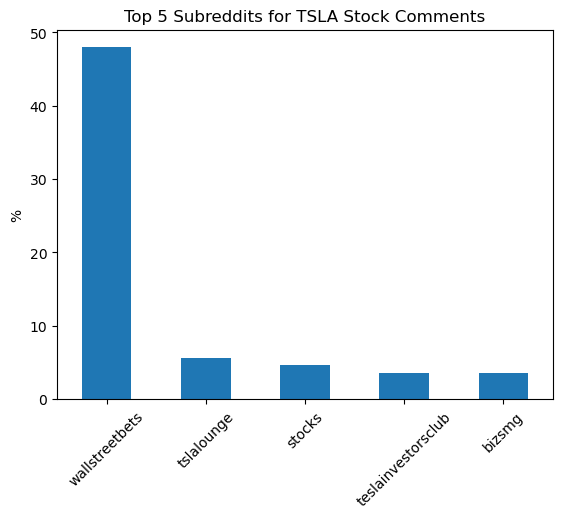

In [ ]:
# plot the top 5 subreddit names for comments
(reddit_comment_df['subreddit.name'].value_counts(normalize=True)*100)[:5].plot(kind='bar')
plt.title('Top 5 Subreddits for TSLA Stock Comments')
plt.ylabel('%')
plt.xticks(rotation=45)
plt.show()

Almost 50% of the posts come from `wallstreetbets`. That is great insight for users. If you are interested in learning more and following posts about a specific company, take a look at the wallstreetbets subreddit.

In [ ]:
# check the split for where the most posts are posted
reddit_posts_df['subreddit.name'].value_counts()

wallstreetbets           2124
ultraalgo                 826
teslainvestorsclub        758
ev_trading_community      629
optionmillionaires        488
                         ... 
u_-afro_senpai-             1
bscgems                     1
personalfinancecanada       1
u_electronic_ad8315         1
u_near_he                   1
Name: subreddit.name, Length: 1178, dtype: int64

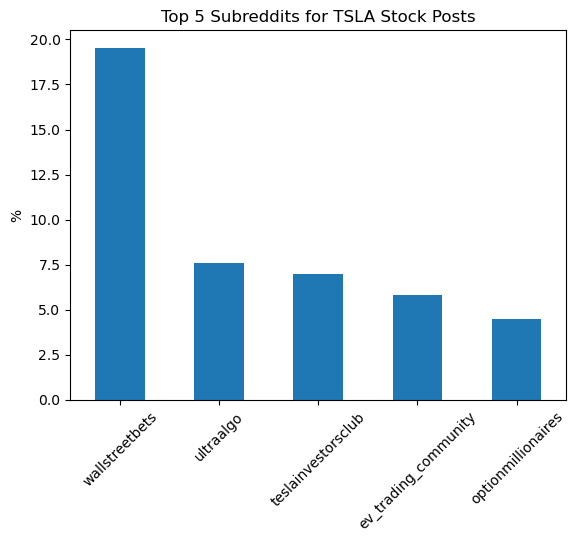

In [ ]:
# plot the top 5 subreddit names for posts

(reddit_posts_df['subreddit.name'].value_counts(normalize=True)*100)[:5].plot(kind='bar')
plt.title('Top 5 Subreddits for TSLA Stock Posts')
plt.ylabel('%')
plt.xticks(rotation=45)
plt.show()

Almost 20% of all posts are from the same subreddit as the above analysis of the comments -- wallstreetbets.

Interesting to see which subreddits are being utilized for this analysis. For both posts and comments we see the number one location to post is `wallstreetbets`. Although, there is more of a distribution for Posts.

Convert the date column (`created_utc`) to a format more legible to humans.

In [ ]:
# what format is the date in? The date, created_utc is in Seconds
print("Comments Dataframe")
display(reddit_comment_df['created_utc'].sort_values(ascending=False))

print("\n\n\nPosts Data")
display(reddit_posts_df['created_utc'].sort_values(ascending=False))

Comments Dataframe


0         1656978625
1         1656978201
2         1656977438
3         1656976905
4         1656976877
             ...    
218740    1625445862
218741    1625445628
218742    1625443918
218743    1625443792
218744    1625443401
Name: created_utc, Length: 218745, dtype: int64




Posts Data


0        1656977609
1        1656975472
2        1656974317
3        1656971708
4        1656960267
            ...    
10863    1625486416
10864    1625464873
10865    1625461219
10866    1625449615
10867    1625446595
Name: created_utc, Length: 10868, dtype: int64

Convert the date to a more readable format for humans, use the `to_datetime` function. Additionally, we are not interested in the hour:minute:second the thread was posted. Therefore, we will truncate the date to only include the 'date' portion.\
Rename the column to something more understandable.

In [ ]:
# as the created_utc is in format seconds, we will conver to_datetime using the unit set to 's', truncate the date
reddit_comment_df['date_posted'] = pd.to_datetime(reddit_comment_df['created_utc'], unit='s').dt.date

print("Comments Dataframe:")
display(reddit_comment_df['date_posted'].sort_index(ascending=False))


print("\n\n\nPosts Dataframe:")
reddit_posts_df['date_posted'] = pd.to_datetime(reddit_comment_df['created_utc'], unit='s').dt.date
display(reddit_posts_df['date_posted'].sort_index(ascending=False))


Comments Dataframe:


218744    2021-07-05
218743    2021-07-05
218742    2021-07-05
218741    2021-07-05
218740    2021-07-05
             ...    
4         2022-07-04
3         2022-07-04
2         2022-07-04
1         2022-07-04
0         2022-07-04
Name: date_posted, Length: 218745, dtype: object




Posts Dataframe:


10867    2022-06-08
10866    2022-06-08
10865    2022-06-08
10864    2022-06-08
10863    2022-06-08
            ...    
4        2022-07-04
3        2022-07-04
2        2022-07-04
1        2022-07-04
0        2022-07-04
Name: date_posted, Length: 10868, dtype: object

We see that there are some differences in the datasets based on the dates they are created. Due to this we will truncate the Posts Data frame to be the same date frame as the Comments data frame.

In [ ]:
# What is the date range of interest
min_date = reddit_comment_df['date_posted'].min()
max_date = reddit_comment_df['date_posted'].max()

print(f"Date range is from {min_date} to {max_date}.")

Date range is from 2021-07-05 to 2022-07-04.


In [ ]:
reddit_posts_df['date_posted'].min()

datetime.date(2022, 6, 8)

The date range falls outside of the 1 year data collected for the Comments data frame. This will skew data post June 2022. We will drop this data frame from our analysis and only keep the `Comments` data frame.

From the range of dates provided, we can see that the dataset includes posts from 2021-July-5 to 2022-July-4. One full year collected.

In [ ]:
# only interested in the comments dataframe
reddit_df = reddit_comment_df

Can drop the `created_utc` column as this is not needed anymore, the date is captured under `date_posted` column.

In [ ]:
reddit_df.drop(columns='created_utc', inplace=True)

In [ ]:
reddit_df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,permalink,body,sentiment,score,date_posted
0,comment,ievql0n,2rndg,valueinvesting,False,https://old.reddit.com/r/ValueInvesting/commen...,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1,2022-07-04
1,comment,ievpqay,2qjfk,stocks,False,https://old.reddit.com/r/stocks/comments/vrje7...,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04
2,comment,ievo646,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,TSLA 🚀🚀🚀🚀🚀🚀🚀,NaN,4,2022-07-04
3,comment,ievn2mn,2qstm,personalfinance,False,https://old.reddit.com/r/personalfinance/comme...,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04
4,comment,ievn0i7,2qstm,personalfinance,False,https://old.reddit.com/r/personalfinance/comme...,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04


### Check for Null/NaN values and Duplicates

***Note:*** For this analysis `Null` and `NaN` will be used interchangeably.

In [ ]:
# check how many null values are in the data set
reddit_df.isnull().sum().sum()

21332

There are 21,332 null values in the entire dataset, we will dig deeper to see where these null values are located.

In [ ]:
reddit_df.isnull().sum()

type                  0
id                    0
subreddit.id          0
subreddit.name        0
subreddit.nsfw        0
permalink             0
body                  0
sentiment         21332
score                 0
date_posted           0
dtype: int64

All the null values are found within the `sentiment` column. As this is the target feature we need to determine what is the best approach to correct these null values.

There are several options:
- Remove all null values and corresponding rows
- Pre-fill the Null values with the mean value of sentiment
- Pre-fill the Null values with the median value of sentiment

In [ ]:
# show the null values and corresponding row data
reddit_df.loc[reddit_df['sentiment'].isnull() == True]

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,permalink,body,sentiment,score,date_posted
2,comment,ievo646,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,TSLA 🚀🚀🚀🚀🚀🚀🚀,NaN,4,2022-07-04
19,comment,ievg3ss,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,!banbet tsla 420 25d,NaN,4,2022-07-04
23,comment,iev9ape,37kf9c,tslalounge,False,https://old.reddit.com/r/TSLALounge/comments/v...,Fuck yeah! Freeeeeedom!!!! RRRRRRRRREEEEEEEEEE...,NaN,3,2022-07-04
34,comment,ieuzdhc,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,TSLA is overvalued.,NaN,5,2022-07-04
42,comment,ieujzaw,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,"Positions?\n\nMe: TSLA 650p, 605p 7/15, 8/17",NaN,1,2022-07-04
...,...,...,...,...,...,...,...,...,...,...
218698,comment,h43v0gu,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,Puts not on TSLA,NaN,1,2021-07-05
218707,comment,h43j3dp,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,TSLA of course,NaN,4,2021-07-05
218710,comment,h43he3z,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,TSLA,NaN,2,2021-07-05
218715,comment,h43gvfc,36z35,singaporefi,False,https://old.reddit.com/r/singaporefi/comments/...,"\nOtcm: GGII, UMAX, WSRC, QNTA HYSR\n\n\nOther...",NaN,1,2021-07-05


In [ ]:
# check what percentage of the data contains null values
print(f"The percentage of null values in the data set is {round((reddit_df.sentiment.isnull().sum())/(reddit_df.sentiment.count())*100, 1)}% of the entire dataset.")

The percentage of null values in the data set is 10.8% of the entire dataset.


Only 10% of the data contains null values, this means dropping the nulls is a viable option. For this project we will not, we will adjust the values to correct the nulls.

In [ ]:
reddit_df[['sentiment']].describe()

,sentiment
count,197413.000000
mean,0.165335
std,0.503514
min,-0.999300
25%,-0.077200
50%,0.000000
75%,0.585900
max,0.999900


In [ ]:
reddit_df['sentiment'].value_counts()

 0.0000    46943
 0.4404     3127
 0.3612     3091
 0.2960     2225
 0.4215     2168
           ...  
-0.2712        1
-0.8373        1
-0.7254        1
 0.5345        1
-0.3569        1
Name: sentiment, Length: 13851, dtype: int64

In [ ]:
pos_sentiment_count = reddit_df[reddit_df['sentiment'].isnull() == False].query("sentiment > 0").count()[0]
neg_sentiment_count = reddit_df[reddit_df['sentiment'].isnull() == False].query("sentiment <= 0").count()[0]

print(f"In the dataset we see a total {pos_sentiment_count} positive reviews")
print(f"In the dataset we see a total {neg_sentiment_count} negative reviews")
print(f"There are {reddit_df.isnull().sum().sum()} null values in the data.")


In the dataset we see a total 98345 positive reviews
In the dataset we see a total 99068 negative reviews
There are 21332 null values in the data.


From the above we can see that the split from positive and negative reviews is already pretty even. If we are to fill the nulls with the median we will offset this amount and the sentiment will be heavily favored to negative. Since the null data is only 10% of the overall data we can drop these columns. But first we need to check if there is data stored for every day of the year from July 4 2021 to July 5 2022.

This is essential as we will be using this as an average and merging it to the final stock dataset in Book 3. We want to have a sentiment associated with each day of the year.

In [ ]:
# we want to create a variable to set the full range of the data to it
first_day = reddit_comment_df['date_posted'].min()
last_day = reddit_comment_df['date_posted'].max()

full_range = pd.date_range(start=first_day, end=last_day, freq="D")
full_range.difference(reddit_df['date_posted'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

We calculated the difference between the first day and last, we were able to determine that there is a post for every day of the year (July 2021 to July 2022). This is good, as we need this when merging the stock dataset in Book 3.

We can drop the null values, but when dropping we will want to run the date analysis again to make sure we did not lose any of the days.

In [ ]:
copy = reddit_df.copy()
copy = copy.dropna()

print(copy.shape)
print(reddit_df.shape)

# are we including all days from first and last
full_range.difference(copy['date_posted'])

(197413, 10)
(218745, 10)


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

We can see that even after dropping all null values, our data frame contains all days of the year (Jul-2021 to Jul-2022).

Now complete the dropna to the original data set.

In [ ]:
reddit_df = reddit_df.dropna()
print(f"The new dataset has {reddit_df.shape[0]} rows and {reddit_df.shape[1]} columns.")

The new dataset has 197413 rows and 10 columns.


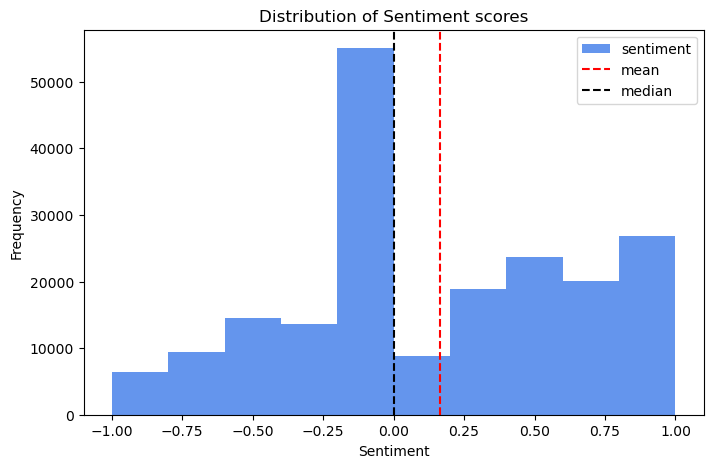

In [ ]:
# Plot the sentiment distribution
plt.figure(figsize=(8,5))
reddit_df['sentiment'].plot(kind='hist', bins=10, color='cornflowerblue')
plt.xlabel('Sentiment')
plt.axvline(reddit_df['sentiment'].mean(), c='red', ls='--', label='mean')
plt.axvline(reddit_df['sentiment'].median(), c='black', ls='--', label='median')

plt.legend()
plt.title("Distribution of Sentiment scores")
plt.show()

The data does not follow a normal distribution, but we see majority of the data is at 0 (which is the median). This makes sense, as it is difficult to initially asses the sentiment of text -- that means most likely the pre trained model predicted overwhelmingly neutral. We will dig deeper into this once we complete out sentiment scoring.

In [ ]:
# check for duplicated rows
reddit_df.duplicated().sum()

0

There are no duplicated records in the dataset.

Now we can take care of the null/nan values in the data -- the best approach will be to fill the nulls using the data median value. This will work as the majority of the data is

In [ ]:
reddit_df.isnull().sum()

type              0
id                0
subreddit.id      0
subreddit.name    0
subreddit.nsfw    0
permalink         0
body              0
sentiment         0
score             0
date_posted       0
dtype: int64

### Remove Features that are not needed

In [ ]:
reddit_df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,permalink,body,sentiment,score,date_posted
0,comment,ievql0n,2rndg,valueinvesting,False,https://old.reddit.com/r/ValueInvesting/commen...,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1,2022-07-04
1,comment,ievpqay,2qjfk,stocks,False,https://old.reddit.com/r/stocks/comments/vrje7...,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04
3,comment,ievn2mn,2qstm,personalfinance,False,https://old.reddit.com/r/personalfinance/comme...,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04
4,comment,ievn0i7,2qstm,personalfinance,False,https://old.reddit.com/r/personalfinance/comme...,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04
5,comment,ievmj40,2th52,wallstreetbets,False,https://old.reddit.com/r/wallstreetbets/commen...,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04


In [ ]:
remove_col = []
reddit_df.type.value_counts()

comment    197413
Name: type, dtype: int64

The `type` feature gives us no information as all the rows are "comment". This will be removed.

In [ ]:
remove_col.append('type')

In [ ]:
# are the id's associated to a person or each comment
reddit_df.id.value_counts()

ievql0n    1
hk9uq2v    1
hkahdz1    1
hkahbfm    1
hkahb2f    1
          ..
hysfv6d    1
hysfmsk    1
hysfgrr    1
hysf9xn    1
h42t9mb    1
Name: id, Length: 197413, dtype: int64

Each `id` is associated to a single comment, this means it is a identifier. This is not needed as we are associating each comment with the `index`.

In [ ]:
remove_col.append('id')

In [ ]:
print("Subreddit ID Column")
display(reddit_df['subreddit.id'].value_counts())

print("\n\n\nSubreddit Name Column")
display(reddit_df['subreddit.name'].value_counts())

Subreddit ID Column


2th52     91856
37kf9c    11810
2qjfk      9523
4weg82     7861
n9evv      7749
          ...  
2qur9         1
43rm4z        1
4swokl        1
ccr21         1
4poik3        1
Name: subreddit.id, Length: 2126, dtype: int64




Subreddit Name Column


wallstreetbets        91856
tslalounge            11810
stocks                 9523
bizsmg                 7861
teslainvestorsclub     7749
                      ...  
warmstocks                1
chodi                     1
fursuit                   1
trumpvirus                1
stockchoice               1
Name: subreddit.name, Length: 2118, dtype: int64

Columns `subreddit_id` and `subreddit_name` are providing the exact same information. Name can be referenced easier than id, drop subreddit_id.

In [ ]:
remove_col.append('subreddit.id')

The `subreddit_nsfw` is not needed, drop. Same with the link, this is not useful to us for this sentiment scoring. All other columns can be kept.

The feature `score` is an interesting one. It takes into account upvotes, downvotes, the number of likes, and shares and clumps it into one compounding variable. This will be used to calculate the weight of the sentiment.

***Note: we will be keeping sentiment as a continuous variable rather than a categorical.***

In [ ]:
remove_col.append('subreddit.nsfw')

In [ ]:
remove_col.append('permalink')

In [ ]:
# remove_col and reset index
reddit_df = reddit_df.drop(columns=remove_col, axis=1).reset_index()

In [ ]:
# becasue we reset the index, need to drop the index col
reddit_df.drop(columns='index', inplace=True)

In [ ]:
reddit_df

,subreddit.name,body,sentiment,score,date_posted
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1,2022-07-04
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04
...,...,...,...,...,...
197408,thetagang,Yeah like this week pretty much has nothing. ...,0.9403,2,2021-07-05
197409,stocks,I invested with TSLA 2 years ago with this in ...,0.9239,34,2021-07-05
197410,valueinvesting,"It was, at 1 point, $400/share. At $200, compa...",0.5544,4,2021-07-05
197411,wallstreetbets,Guy taking 2nd mortgage for MU 90 calls. Other...,-0.6486,19,2021-07-05


## Preprocess for VADER

We will get the text data to the correct format prior to feeding it directly into VADER.

In [ ]:
reddit_df['cleaned_posts'] = reddit_df['body']

reddit_df.head()

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1,2022-07-04,When TSLA was at 1K share price :\n\n8B sales/...
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,$TSLA will go down because you own the stock… ...
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,"&gt;What I mean is when I started investing, t..."
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,"I do trade in some ETFs.. DIV, SDIV ; USOI (it..."
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,I think macro runs coming up. Sell and wait fo...


In [ ]:
example = reddit_df['cleaned_posts'][50]

VADER takes all the words within the sentence/post and assigns a value to positive, negative and neutral. This is then compounded to get an overall sentiment score.
- VADER will run this analysis on each word individually and then mathematically define the overall statement sentiment.
- VADER is specifically designed for social media text and informal language -- it can handle emojiis as well.

In [ ]:
# need to download the package to run VADER
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DhimanS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# set up an intensity analyzer -- this will be used to determine the neutral/neg/pos/compound values for our text
sentiment_intensity = SentimentIntensityAnalyzer()

In [ ]:
# trial run of the sentiment analyzer
print(reddit_df['cleaned_posts'][0])
sentiment_intensity.polarity_scores(reddit_df['cleaned_posts'][0])

When TSLA was at 1K share price :

8B sales/1B sales = $8/share 
$1000/$8= 125 

The stocks in the link are under 5 and most under 1 if I remember correctly.


{'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'compound': 0.296}

We can see above the trial run of the sentiment analyzer. The trial seems to work really well. The text was overwhelmingly neutral -- as the statement is just about the breakdown of the stock share. The sentiment analyzer predicted correctly.

## Cleaning the text data in `cleaned_posts`
Lets being with the text cleaning.

***Disclaimer: this cell takes some time.***

In [ ]:
# Required preprocessing for analysis

# lower case
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.lower()

# replace '/' with empty spaces ' '
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("/", ' ', regex=False)

# replace ' :' with empty string ''
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(" :", '', regex=False)

# replace ': ' with space ' '
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(": ", ' ', regex=False)

#replace "'" with empty string ''
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("'", '', regex=False)

# remove periods with empty string '' for end of sentences
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(".", '', regex=False)

# comma inbetween words
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r"([a-z]),([a-z])", r'\1 \2', regex=True)

# remove periods with empty space ' ' for inbetween sentence
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r"([a-z]),([0-9\.])", r'\1 \2', regex=True)

# any numbers that contain ',' i.e. 1,000, etc. -- want to replace with empty string
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([0-9]),([0-9])', r'\1\2', regex=True)

reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([a-z])\'([a-z])', r'\1\2', regex=True)

# replace the comma inbetween sentence with space
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(", ", ' ', regex=False)

# replace the double comma with space
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(",, ", ' ', regex=False)

# ,,,,,, replace with ' '
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(",,,,,,", ' ', regex=False)

# replace $ with empty
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("$", '', regex=False)

# replace '= ' with ' '
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("= ", ' ', regex=False)

# replace '? ' with ' '
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("? ", ' ', regex=False)

# replace multiple periods
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'(\.){2,}', ' ', regex=True)

#replace * with empty
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("*", '', regex=False)

# replace % following number with empty
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace('[0-9]%', '', regex=True)

# replace multiple spaces with single space
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(' +', ' ', regex=True)

# remove any punctuation at the end of statements
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.strip(' .!%()?-,')

# remove paranthesis, and square brackets
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("(", ' ', regex=False)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(")", ' ', regex=False)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("[", ' ', regex=False)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace("]", ' ', regex=False)

# replace seperating hyphens
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(' - ', ' ', regex=False)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([a-z])-([a-z])', r'\1 \2', regex=True)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([0-9])-([0-9])', r'\1 to \2', regex=True)

# regex remove and '&' followed by text
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'&([a-z])', r' and \1', regex=True)

# regex remove any '!' after text or numbers
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([a-z])!', r'\1 ', regex=True)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([0-9])!', r'\1 ', regex=True)

# remove '\n' from text
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'\\n([a-z])', r' \1', regex=True)

# remove ;n~ from text
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace('[;\n~]', ' ', regex=True)

# replace '#' '@' followed by number or text, and if it is anywhere else in the text
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace('#[a-z0-9]+', '', regex=True)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace('@[a-z0-9]+', '', regex=True)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace('#', '', regex=False)
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace('@', '', regex=False)

# remove all major special characters
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r"[\"\'\|\?\=\.\>\<\@\#\*\,]", '')

# regex if there is a 'k' after a number, replace with 'thousand'
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([0-9])k ', r'\1 thousand', regex=True)

# regex if there is a 'b' after a number, replace with 'billion'
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([0-9])b ', r'\1 billion', regex=True)

# regex if there is a 'm' after a number, replace with 'million'
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r'([0-9])m ', r'\1 million', regex=True)

# replace backslash
reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].str.replace(r"[\\]", '')

In [ ]:
# just to get an overview of the changes made above
reddit_df['cleaned_posts'].sample(10)

119530    why does tsla ever moon seems to go up and dow...
183913    dont think its as complicated as thatonly thin...
78120                      tsla crashing into close lmaoooo
146314    tesla stock has a 10-year cagr of 6 no way tsl...
34017     paper hands rick strikes again dupped those ts...
39674     this is my bear stance on tsla bulls love to r...
87256     how tf can cathie wood say “value stocks are i...
138472    nah this is what he wanted or else he wouldn’t...
74046     thats a lot volatility always eats up my tsla ...
184791    i like the tsla bike shorts for running i get ...
Name: cleaned_posts, dtype: object

In [ ]:
reddit_df.head()

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1,2022-07-04,when tsla was at 1 thousandshare price 8 bill...
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,tsla will go down because you own the stock… t...
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,and gt what i mean is when i started investin...
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,i do trade in some etfs div sdiv usoi its a...
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,i think macro runs coming up sell and wait for...


We can see the preprocessing looks good, the `cleaned_posts` feature is in good format for VADER sentiment analysis.

### Remove Stop Words

---
***Due to the excessively long compute time for the stop words removal, I will comment out this section and export the data to a .csv. Then read in to a new data frame. This will eliminate that long wait time.***

In [ ]:
# # need to download the package first

nltk.download('stopwords')
# stop_words = stopwords.words('english')
# # stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DhimanS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# # create a function that will remove the stop words in the dataframe

# def remove_stop(post):
#   words = nltk.word_tokenize(post)
#   filter_words = [i for i in words if i.lower() not in stopwords.words('english')]
#   return ' '.join(filter_words)


***Disclaimer: this step will take a lot of time.***

In [ ]:
# reddit_df['cleaned_posts'] = reddit_df['cleaned_posts'].apply(remove_stop)

---

In [ ]:
reddit_df.head()

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1,2022-07-04,when tsla was at 1 thousandshare price 8 bill...
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,tsla will go down because you own the stock… t...
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,and gt what i mean is when i started investin...
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,i do trade in some etfs div sdiv usoi its a...
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,i think macro runs coming up sell and wait for...


## Sentiment Scoring using VADER

In [ ]:
# # export the final dataframe to a csv to use in Book 3: Modeling
# reddit_df.to_csv('data/reddit_stopwords_removed.csv')

In [ ]:
# load in the saved data
reddit = pd.read_csv('data/reddit_stopwords_removed.csv')

In [ ]:
# need to drop this from the exported data, forgot to ignore the index when exporting
reddit = reddit.drop(columns=['Unnamed: 0'])

In [ ]:
# the date_posted column was type object -- convert
reddit['date_posted'] = pd.to_datetime(reddit['date_posted'])

In [ ]:
# what data type is being stored in the new cleanted tewxt data
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197420 entries, 0 to 197419
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subreddit.name  197414 non-null  object        
 1   body            197414 non-null  object        
 2   sentiment       197413 non-null  object        
 3   score           197413 non-null  object        
 4   date_posted     197412 non-null  datetime64[ns]
 5   cleaned_posts   197411 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 9.0+ MB


In [ ]:
reddit.head()

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.296,1,2022-07-04,tsla 1 thousandshare price 8 billionsales 1 bi...
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,tsla go stock… best way make price go sell it…...
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,gt mean started investing thats came highly re...
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,trade etfs div sdiv usoi etn im real sure gut ...
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,think macro runs coming sell wait big crash bu...


In [ ]:
# set up an intensity analyzer -- this will be used to determine the neutral/neg/pos/compound values for our text
sia = SentimentIntensityAnalyzer()

***Disclaimer: this will take roughly 3min to run***

In [ ]:
%%time
# needed to use .astype(str) because there were some text data that was type float, so to run VADER analysis needed to convert to string
reddit['vader'] = reddit['cleaned_posts'].astype(str).apply(lambda x: sia.polarity_scores(x))

CPU times: total: 2min 1s
Wall time: 2min 1s


In [ ]:
# the VADER polasrity scoring outputs a dictionary of negative, neutral, positive and compounded sentiment scores
reddit

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts,vader
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.296,1,2022-07-04,tsla 1 thousandshare price 8 billionsales 1 bi...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp..."
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,tsla go stock… best way make price go sell it…...,"{'neg': 0.048, 'neu': 0.655, 'pos': 0.296, 'co..."
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,gt mean started investing thats came highly re...,"{'neg': 0.061, 'neu': 0.707, 'pos': 0.232, 'co..."
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,trade etfs div sdiv usoi etn im real sure gut ...,"{'neg': 0.087, 'neu': 0.807, 'pos': 0.107, 'co..."
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,think macro runs coming sell wait big crash bu...,"{'neg': 0.152, 'neu': 0.73, 'pos': 0.118, 'com..."
...,...,...,...,...,...,...,...
197415,thetagang,Yeah like this week pretty much has nothing. ...,0.9403,2,2021-07-05,yeah like week pretty much nothing cases try s...,"{'neg': 0.069, 'neu': 0.494, 'pos': 0.437, 'co..."
197416,stocks,I invested with TSLA 2 years ago with this in ...,0.9239,34,2021-07-05,invested tsla 2 years ago mind year year expon...,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp..."
197417,valueinvesting,"It was, at 1 point, $400/share. At $200, compa...",0.5544,4,2021-07-05,1 point 400 share 200 compared tsla outrageous...,"{'neg': 0.114, 'neu': 0.722, 'pos': 0.163, 'co..."
197418,wallstreetbets,Guy taking 2nd mortgage for MU 90 calls. Other...,-0.6486,19,2021-07-05,guy taking 2nd mortgage mu 90 calls degenerate...,"{'neg': 0.202, 'neu': 0.798, 'pos': 0.0, 'comp..."


We see that the VADER sentiment analysis gives us a dictionary of neg/pos/neu/compound sentiment. We want to expand these to their own columns. We can use the pandas method `.json_normalize()`.

In [ ]:
# expand the vader column of dictionaries -- use pandas method json.normalize
sentiment_expanded = pd.json_normalize(reddit['vader'])

In [ ]:
#created a standalone sentiment dataframe
sentiment_expanded

,neg,neu,pos,compound
0,0.000,0.833,0.167,0.2960
1,0.048,0.655,0.296,0.8658
2,0.061,0.707,0.232,0.6223
3,0.087,0.807,0.107,0.0772
4,0.152,0.730,0.118,-0.1531
...,...,...,...,...
197415,0.069,0.494,0.437,0.9169
197416,0.000,0.682,0.318,0.9793
197417,0.114,0.722,0.163,0.0772
197418,0.202,0.798,0.000,-0.6486


We will now want to concatenate this data frame to the original.

In [ ]:
# concatenate the 2 dataframes, use axis=1 as we are merging with the columns -- this will work as the index matches
reddit = pd.concat([reddit, sentiment_expanded], axis=1)

In [ ]:
reddit

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts,vader,neg,neu,pos,compound
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.296,1,2022-07-04,tsla 1 thousandshare price 8 billionsales 1 bi...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.000,0.833,0.167,0.2960
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,tsla go stock… best way make price go sell it…...,"{'neg': 0.048, 'neu': 0.655, 'pos': 0.296, 'co...",0.048,0.655,0.296,0.8658
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,gt mean started investing thats came highly re...,"{'neg': 0.061, 'neu': 0.707, 'pos': 0.232, 'co...",0.061,0.707,0.232,0.6223
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,trade etfs div sdiv usoi etn im real sure gut ...,"{'neg': 0.087, 'neu': 0.807, 'pos': 0.107, 'co...",0.087,0.807,0.107,0.0772
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,think macro runs coming sell wait big crash bu...,"{'neg': 0.152, 'neu': 0.73, 'pos': 0.118, 'com...",0.152,0.730,0.118,-0.1531
...,...,...,...,...,...,...,...,...,...,...,...
197415,thetagang,Yeah like this week pretty much has nothing. ...,0.9403,2,2021-07-05,yeah like week pretty much nothing cases try s...,"{'neg': 0.069, 'neu': 0.494, 'pos': 0.437, 'co...",0.069,0.494,0.437,0.9169
197416,stocks,I invested with TSLA 2 years ago with this in ...,0.9239,34,2021-07-05,invested tsla 2 years ago mind year year expon...,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp...",0.000,0.682,0.318,0.9793
197417,valueinvesting,"It was, at 1 point, $400/share. At $200, compa...",0.5544,4,2021-07-05,1 point 400 share 200 compared tsla outrageous...,"{'neg': 0.114, 'neu': 0.722, 'pos': 0.163, 'co...",0.114,0.722,0.163,0.0772
197418,wallstreetbets,Guy taking 2nd mortgage for MU 90 calls. Other...,-0.6486,19,2021-07-05,guy taking 2nd mortgage mu 90 calls degenerate...,"{'neg': 0.202, 'neu': 0.798, 'pos': 0.0, 'comp...",0.202,0.798,0.000,-0.6486


In [ ]:
# drop the original vader column
reddit = reddit.drop(columns = 'vader')

In [ ]:
reddit

,subreddit.name,body,sentiment,score,date_posted,cleaned_posts,neg,neu,pos,compound
0,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.296,1,2022-07-04,tsla 1 thousandshare price 8 billionsales 1 bi...,0.000,0.833,0.167,0.2960
1,stocks,$TSLA will go down because you own the stock… ...,0.2136,1,2022-07-04,tsla go stock… best way make price go sell it…...,0.048,0.655,0.296,0.8658
2,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8,2022-07-04,gt mean started investing thats came highly re...,0.061,0.707,0.232,0.6223
3,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2,2022-07-04,trade etfs div sdiv usoi etn im real sure gut ...,0.087,0.807,0.107,0.0772
4,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1,2022-07-04,think macro runs coming sell wait big crash bu...,0.152,0.730,0.118,-0.1531
...,...,...,...,...,...,...,...,...,...,...
197415,thetagang,Yeah like this week pretty much has nothing. ...,0.9403,2,2021-07-05,yeah like week pretty much nothing cases try s...,0.069,0.494,0.437,0.9169
197416,stocks,I invested with TSLA 2 years ago with this in ...,0.9239,34,2021-07-05,invested tsla 2 years ago mind year year expon...,0.000,0.682,0.318,0.9793
197417,valueinvesting,"It was, at 1 point, $400/share. At $200, compa...",0.5544,4,2021-07-05,1 point 400 share 200 compared tsla outrageous...,0.114,0.722,0.163,0.0772
197418,wallstreetbets,Guy taking 2nd mortgage for MU 90 calls. Other...,-0.6486,19,2021-07-05,guy taking 2nd mortgage mu 90 calls degenerate...,0.202,0.798,0.000,-0.6486


In [ ]:
# check to see what the data stored in sentiment is?
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197420 entries, 0 to 197419
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subreddit.name  197414 non-null  object        
 1   body            197414 non-null  object        
 2   sentiment       197413 non-null  object        
 3   score           197413 non-null  object        
 4   date_posted     197412 non-null  datetime64[ns]
 5   cleaned_posts   197411 non-null  object        
 6   neg             197420 non-null  float64       
 7   neu             197420 non-null  float64       
 8   pos             197420 non-null  float64       
 9   compound        197420 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 15.1+ MB


We can see that the sentiment is actually type object. This needs to be converted to float for comparisons.\
***Note:*** sentiment has a lot of different data stored, could not convert because it had a date stored.

In [ ]:
# to convert the column to numeric without errors, this is used if there is unsupported formats in the columns
# errors='coerce' will convert those weird formats to NaN
reddit['sentiment'] = pd.to_numeric(reddit['sentiment'], errors='coerce')

# reddit['sentiment']=reddit['sentiment'].astype(float) -- error as there are differnt formats of text in the column

In [ ]:
reddit.isnull().sum()

subreddit.name    6
body              6
sentiment         8
score             7
date_posted       8
cleaned_posts     9
neg               0
neu               0
pos               0
compound          0
dtype: int64

We can see there are several null values now. We are only interested in the sentiment for now, we will fill the nulls with the median value.

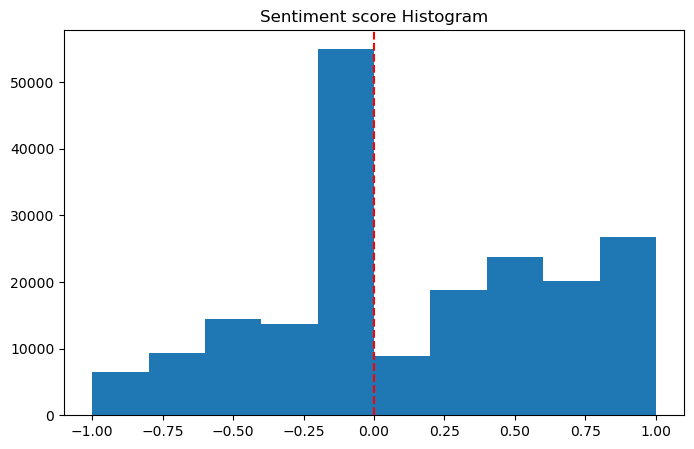

In [ ]:
# sentiment distribution
plt.figure(figsize=(8,5))
plt.axvline(reddit.sentiment.median(), c='red', ls='--')
plt.hist(reddit['sentiment'])
plt.title('Sentiment score Histogram')
plt.show()

In [ ]:
# fill the null values in teh sentiment score with median
reddit.sentiment = reddit.sentiment.fillna(reddit.sentiment.median())

In [ ]:
# check to see if the sentiment null values are filled.
reddit.isnull().sum()

subreddit.name    6
body              6
sentiment         0
score             7
date_posted       8
cleaned_posts     9
neg               0
neu               0
pos               0
compound          0
dtype: int64

We can compare how our new sentiment (VADER) scoring compares -- `compound`.

In [ ]:
# create a new column to compare the new sentiment 'compound' to the pretrained sentiment
reddit['compare_sentiment'] = np.where(reddit['sentiment'] == reddit['compound'], 1, 0)
reddit['compare_sentiment'].value_counts()

1    109459
0     87961
Name: compare_sentiment, dtype: int64

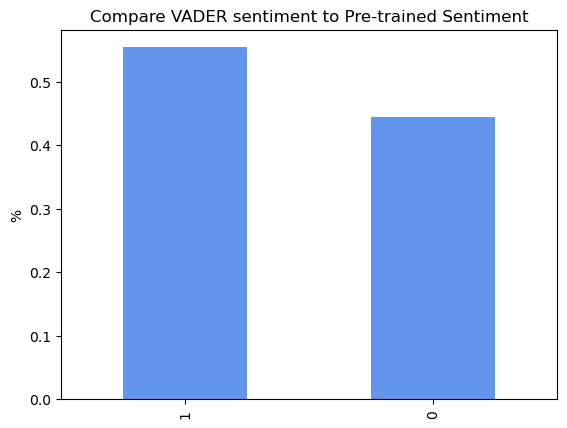

In [ ]:
reddit['compare_sentiment'].value_counts(normalize=True).plot(kind='bar', color='cornflowerblue')
plt.title("Compare VADER sentiment to Pre-trained Sentiment")
plt.ylabel('%')

plt.show()

We can see that the VADER model predicted well. More than 50% accurate to the pre-trained model. This variance can be from differing float values. We can run the analysis by binarizing the two columns and then re-run the check.

In [ ]:
# re-run the test with integers
# create new testing columns and binarize the compound and sentiment columns to compare their performance with eachother
reddit['int_compound'] = np.where(reddit['compound']>0,1,0)
reddit['int_sentiment'] = np.where(reddit['sentiment']>0,1,0)
reddit['compare_sentiment_test_2'] = np.where(reddit['int_sentiment'] == reddit['int_compound'], 1, 0)
reddit['compare_sentiment_test_2'].value_counts()

1    182119
0     15301
Name: compare_sentiment_test_2, dtype: int64

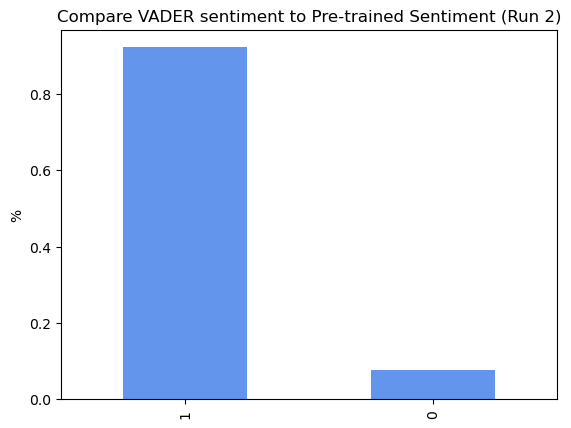

In [ ]:
reddit['compare_sentiment_test_2'].value_counts(normalize=True).plot(kind='bar', color='cornflowerblue')
plt.title("Compare VADER sentiment to Pre-trained Sentiment (Run 2)")
plt.ylabel('%')

plt.show()

When we take away the variance from floats -- we are comparing positive sentiment (>0) and negative (<=0). We binarized the columns and now we can see that our VADER model predicted very well. We can see we captured the positive and negative sentiment really well. Therefore we will keep the VADER scores and drop the `sentiment` column as they are essentially capturing the same data. We will also drop all the remaining unneeded columns.

In [ ]:
reddit.head(2)

#drop columns that we are not interested in -- sentiment, body, compare_setiment, compare_sentiment_test_2, int_compound, int_sentiment
reddit = reddit.drop(columns=['sentiment', 'body', 'compare_sentiment', 'compare_sentiment_test_2', 'int_compound', 'int_sentiment'])

In [ ]:
reddit

,subreddit.name,score,date_posted,cleaned_posts,neg,neu,pos,compound
0,valueinvesting,1,2022-07-04,tsla 1 thousandshare price 8 billionsales 1 bi...,0.000,0.833,0.167,0.2960
1,stocks,1,2022-07-04,tsla go stock… best way make price go sell it…...,0.048,0.655,0.296,0.8658
2,personalfinance,8,2022-07-04,gt mean started investing thats came highly re...,0.061,0.707,0.232,0.6223
3,personalfinance,-2,2022-07-04,trade etfs div sdiv usoi etn im real sure gut ...,0.087,0.807,0.107,0.0772
4,wallstreetbets,1,2022-07-04,think macro runs coming sell wait big crash bu...,0.152,0.730,0.118,-0.1531
...,...,...,...,...,...,...,...,...
197415,thetagang,2,2021-07-05,yeah like week pretty much nothing cases try s...,0.069,0.494,0.437,0.9169
197416,stocks,34,2021-07-05,invested tsla 2 years ago mind year year expon...,0.000,0.682,0.318,0.9793
197417,valueinvesting,4,2021-07-05,1 point 400 share 200 compared tsla outrageous...,0.114,0.722,0.163,0.0772
197418,wallstreetbets,19,2021-07-05,guy taking 2nd mortgage mu 90 calls degenerate...,0.202,0.798,0.000,-0.6486


It is interesting to see how the sentiment is added to create the compound score. We are interested in the compound and the score. The score will be used as a multiplier to weigh the sentiment based on how influential the comment/post was -- this will technically have a stronger predictive power on the stock movement.

In [ ]:
# check for nulls
reddit.isnull().sum()

subreddit.name    6
score             7
date_posted       8
cleaned_posts     9
neg               0
neu               0
pos               0
compound          0
dtype: int64

Looks like there are some null values. As this is a small amount, drop the records.

In [ ]:
# drop the records that contain null values
reddit = reddit.dropna()

In [ ]:
# recheck to make sure the nulls are all dropped.
reddit.isnull().sum()

subreddit.name    0
score             0
date_posted       0
cleaned_posts     0
neg               0
neu               0
pos               0
compound          0
dtype: int64

### Weighted Sentiment

We want to create a weighting for the sentiment scoring. This is important as not all comments are treated equally -- some have more "power" than others. Power is essentially how many views, shares, likes, upvotes, etc. This is implicated in the `score` column. The score is a conglomerate of all the important factors that are associated with the comment and how popular it is. We will multiply the sentiment and score to get a weighted sentiment score.

In [ ]:
# lets check to see if the data is correctly stored
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197411 entries, 0 to 197419
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subreddit.name  197411 non-null  object        
 1   score           197411 non-null  object        
 2   date_posted     197411 non-null  datetime64[ns]
 3   cleaned_posts   197411 non-null  object        
 4   neg             197411 non-null  float64       
 5   neu             197411 non-null  float64       
 6   pos             197411 non-null  float64       
 7   compound        197411 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 13.6+ MB


In [ ]:
# need to convert the score data to int.
reddit['score'] = reddit['score'].astype(int)

In [ ]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197411 entries, 0 to 197419
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subreddit.name  197411 non-null  object        
 1   score           197411 non-null  int32         
 2   date_posted     197411 non-null  datetime64[ns]
 3   cleaned_posts   197411 non-null  object        
 4   neg             197411 non-null  float64       
 5   neu             197411 non-null  float64       
 6   pos             197411 non-null  float64       
 7   compound        197411 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), object(2)
memory usage: 12.8+ MB


In [ ]:
# check to see how this data look for score
reddit[['score']].describe()

,score
count,197411.000000
mean,5.550309
std,37.769603
min,-264.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,5124.000000


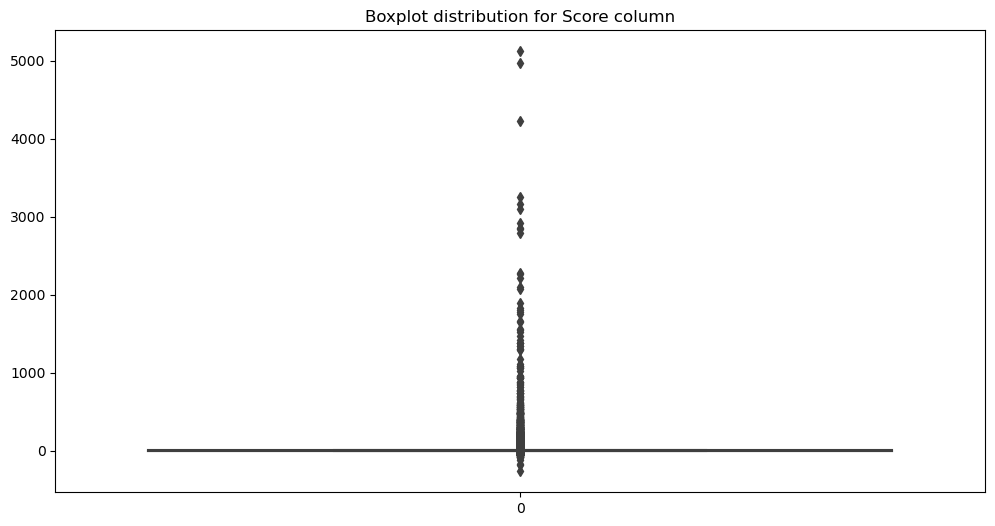

In [ ]:
# distribution of the score metric
plt.figure(figsize=(12,6))

sns.boxplot(reddit['score'])
plt.title('Boxplot distribution for Score column')
plt.show()

The distribution is heavily skewed.

In [ ]:
# create the weighted_sentiment score
reddit['weighted_sentiment'] = reddit['compound']*reddit['score']
reddit

,subreddit.name,score,date_posted,cleaned_posts,neg,neu,pos,compound,weighted_sentiment
0,valueinvesting,1,2022-07-04,tsla 1 thousandshare price 8 billionsales 1 bi...,0.000,0.833,0.167,0.2960,0.2960
1,stocks,1,2022-07-04,tsla go stock… best way make price go sell it…...,0.048,0.655,0.296,0.8658,0.8658
2,personalfinance,8,2022-07-04,gt mean started investing thats came highly re...,0.061,0.707,0.232,0.6223,4.9784
3,personalfinance,-2,2022-07-04,trade etfs div sdiv usoi etn im real sure gut ...,0.087,0.807,0.107,0.0772,-0.1544
4,wallstreetbets,1,2022-07-04,think macro runs coming sell wait big crash bu...,0.152,0.730,0.118,-0.1531,-0.1531
...,...,...,...,...,...,...,...,...,...
197415,thetagang,2,2021-07-05,yeah like week pretty much nothing cases try s...,0.069,0.494,0.437,0.9169,1.8338
197416,stocks,34,2021-07-05,invested tsla 2 years ago mind year year expon...,0.000,0.682,0.318,0.9793,33.2962
197417,valueinvesting,4,2021-07-05,1 point 400 share 200 compared tsla outrageous...,0.114,0.722,0.163,0.0772,0.3088
197418,wallstreetbets,19,2021-07-05,guy taking 2nd mortgage mu 90 calls degenerate...,0.202,0.798,0.000,-0.6486,-12.3234


In [ ]:
reddit.describe()

,score,neg,neu,pos,compound,weighted_sentiment
count,197411.000000,197411.000000,197411.000000,197411.000000,197411.000000,197411.000000
mean,5.550309,0.095589,0.751654,0.152761,0.183994,0.900089
std,37.769603,0.136327,0.187923,0.155252,0.491010,17.768752
min,-264.000000,0.000000,0.000000,0.000000,-0.999000,-1289.301600
25%,1.000000,0.000000,0.625000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.748000,0.131000,0.077200,0.000000
75%,5.000000,0.156000,0.920000,0.249000,0.598400,0.998900
max,5124.000000,1.000000,1.000000,0.960000,0.999800,3224.190600


We can see that the weighted sentiment ranges from -1289 to 3224; whereas the compound ranges from -1 to 1.

Finally, we want to group the posts by date and take the average of the sentiment (compound and weighted_sentiment).

In [ ]:
# test the groupby method before saving to the reddit dataframe
test = reddit.groupby('date_posted').mean()
test

,score,neg,neu,pos,compound,weighted_sentiment
date_posted,,,,,,
2021-07-05,4.600000,0.070193,0.734697,0.195124,0.294246,1.578406
2021-07-06,4.055276,0.098229,0.742857,0.158899,0.159091,0.720461
2021-07-07,4.123324,0.100220,0.730684,0.169102,0.223818,1.499726
2021-07-08,3.215159,0.089870,0.742621,0.167494,0.158081,0.810678
2021-07-09,2.822981,0.090798,0.753494,0.155717,0.161809,0.284380
...,...,...,...,...,...,...
2022-06-30,3.334218,0.119790,0.737374,0.142844,0.107938,0.346758
2022-07-01,4.423611,0.120368,0.739153,0.140493,0.070402,0.165937
2022-07-02,6.173252,0.106751,0.739353,0.153881,0.162170,0.269290


In [ ]:
test.describe()

,score,neg,neu,pos,compound,weighted_sentiment
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,5.341318,0.093948,0.751015,0.155041,0.207996,0.951410
std,2.291044,0.011798,0.012618,0.011642,0.072416,0.961428
min,2.506311,0.038223,0.713844,0.122243,0.058862,-2.843788
25%,4.050485,0.086448,0.742752,0.147023,0.157325,0.489391
50%,4.735568,0.093485,0.750046,0.154821,0.198117,0.772545
75%,5.809793,0.102134,0.759265,0.162524,0.251206,1.292469
max,23.508591,0.131562,0.802345,0.203851,0.496966,7.043988


After applying the groupby method to the date_posted feature, we can see that the range of the weighted_sentiment has change drastically --- ranges from -2.8 to 7.

The data is now ready to collectively be used with the stock data to perform some ML modeling (Book 3).

In [ ]:
# now apply the same to the main dataset
reddit = reddit.groupby('date_posted').mean()

### Export the final reddit data to a csv file.

In [ ]:
reddit.to_csv('data/final_reddit.csv')